In [59]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

In [60]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201

In [61]:
# get frequency evenly spaced out in log scale, between [0, max_sweep_rate // 2]
# offset is used to avoid negative infinity log(offset + x)
def _get_log_freq(sample_rate, max_sweep_rate, offset):

    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, 
    dtype=torch.double)) - offset

In [62]:
# inverse of the log function finds the time where the given frequency is given by _get_log_freq

def _get_inverse_log_freq(freq, sample_rate, offset):
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset ))

In [63]:
# given sample rate used for generating the sweep,
# finds the x-axis value where the log scale major freq. values fall in

def _get_freq_ticks(sample_rate, offset, f_max):
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq

In [64]:
def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

In [65]:
def plot_sweep(waveform, sample_rate, title, max_sweep_rate=48000, offset=DEFAULT_OFFSET):

    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

Resample an audio waveform from one frequency to another precomputes and caches the kernel used for resampling -> torchaudio.transforms.Resample(). However torchaudio.functional.resample() computes it on the fly.

torchaudio.transforms.Resample will result in a speedup when resampling multiple waveforms.

this methods use badlimited sinc interpolation to compute signal values at arbitrary time steps. invlues convolution used to take advantage of GPU / multithreading for performance improvements.

Set torch.set_num_threads(1) to help system manage threads as when using multiple subprocesses application may create more threads than the system can handle efficiently.

Because a finite number of samples can only represent a finite number of frequencies, resampling does not produce perfect results, and a variety of parameters can be used to control for its quality and computational speed. We demonstrate these properties through resampling a logarithmic sine sweep, which is a sine wave that increases exponentially in frequency over time.

The spectrograms below show the frequency representation of the signal, where the x-axis corresponds to the frequency of the original waveform (in log scale), y-axis the frequency of the plotted waveform, and color intensity the amplitude.

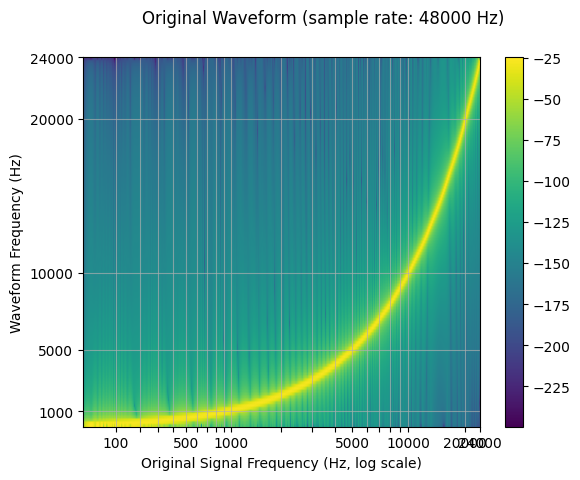

In [66]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

resample (downsample) it. spectogram 

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


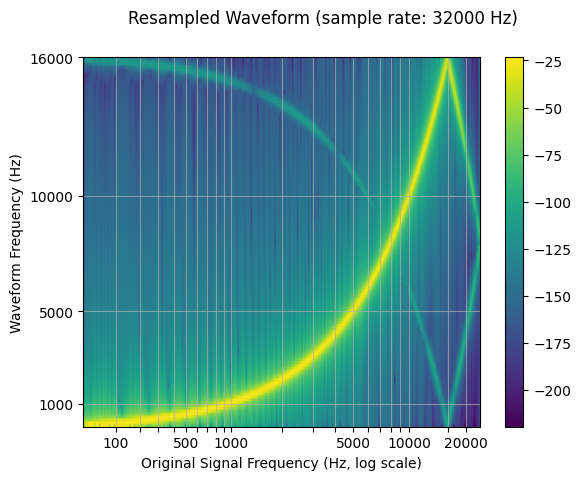

In [67]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

control resamppling quality with parameters - lowpass filter width

filter used for interpolation extends infinitely the lowpass_filter_width parameter is used to control for the width of the filter to use to window the interpolation.

AKA number of zero crossings as interpolation passes through zero at every time unit.

the higher the lowpass_filter_width the sharper, and more pricise the filter, however this comes at the expense of computation.|

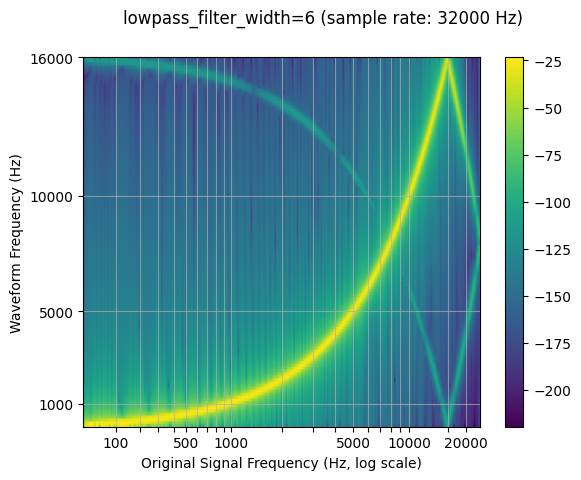

In [71]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

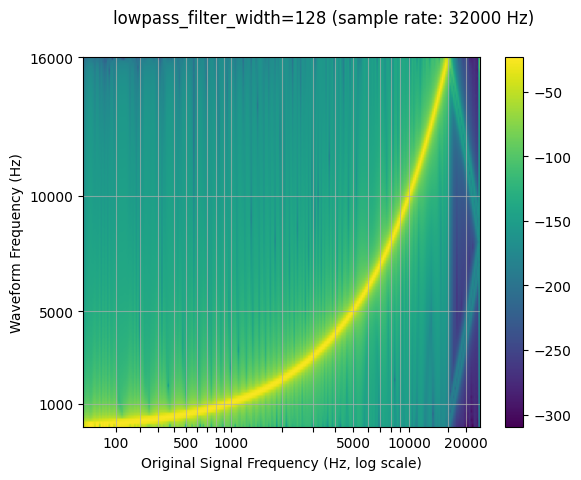

In [72]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

rolloff - represented as a fraction of the Nyquist frequency ( the maximal frequency representable by a given sample rate ) determines the lowpass filter cutoff and controls the degree of aliasing. when the frequencies higher than the Nyquist are mapped to lower frequencies. a lower rolloff will therefor reduce the amount of aliasing, but it will also reduce some of the higher frequencies.

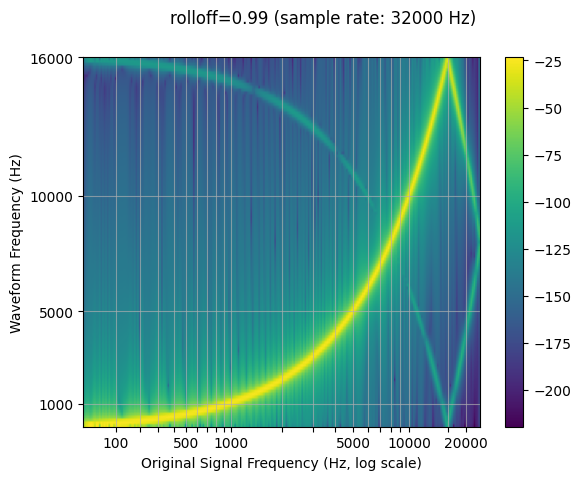

In [76]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

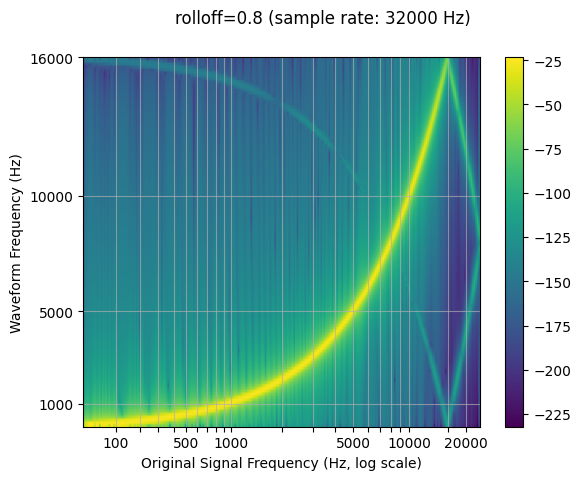

In [77]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

resampling in torchaudio uses the hann window filter -> weighted cosine function.
additional support for kaiser window ( near optimal window function ).
controlled using resampling_method parameter.

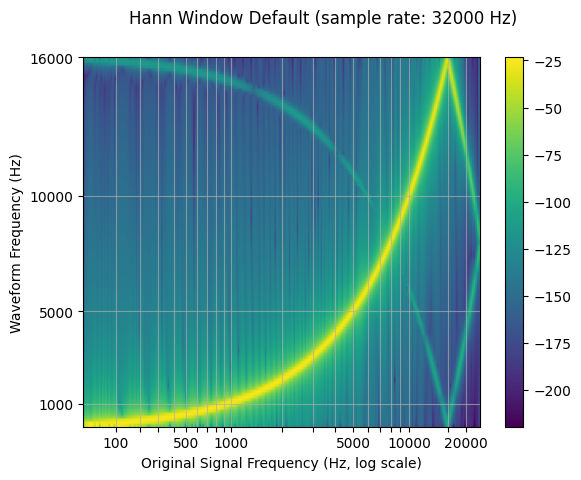

In [78]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

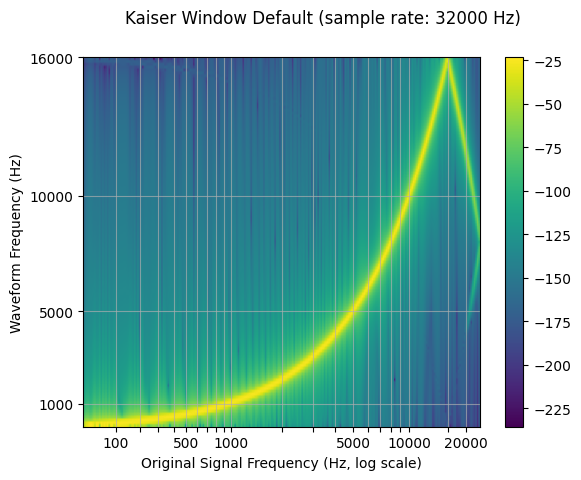

In [80]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate,
resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

can be used to produce results similar to that of librosa [ resampy's kaiser window resampling, with some noise ]

In [83]:
sample_rate = 48000
resample_rate = 32000

# kaiser_best

resampled_waveform = F.resample(
    waveform, 
    sample_rate, 
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)

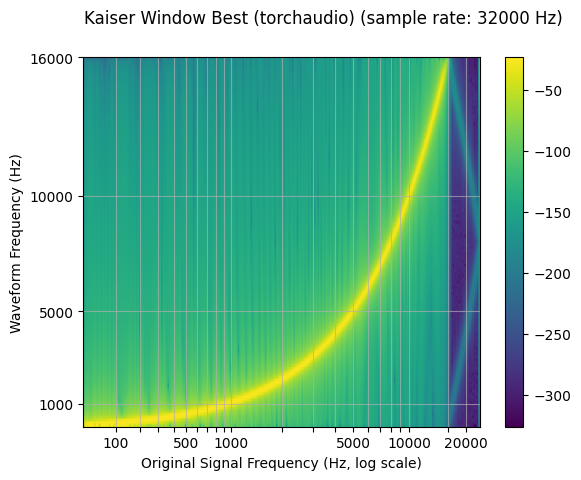

In [84]:
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

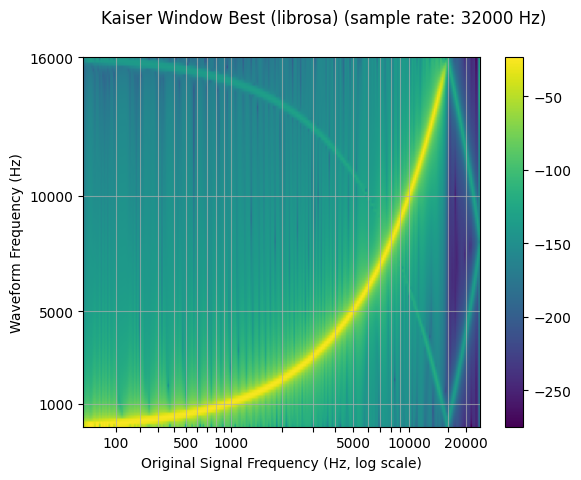

In [85]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [86]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 0.0013004566355607609


Downsampling and upsampling waveforms between two pairs of sampling rates below are the performance implications that the lowpass_filter_width, window type, and sample rates.

a larger lowpass_filter_width results in a larger resampling kernel, and therefore increases computation time for both the kernel computation and convolution.

In [87]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interpolation",
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.monotonic()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.monotonic()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.monotonic()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.monotonic() - begin
        return elapsed / iters

In [88]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
    times, rows = [], []
    sample_rate = configs[label][0]
    resample_rate = configs[label][1]
    waveform = get_sine_sweep(sample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_best")

    # kaiser fast
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"], df.columns])

    print(f"torchaudio: {torchaudio.__version__}")
    print(f"librosa: {librosa.__version__}")
    display(df.round(2))

torchaudio: 0.13.0
librosa: 0.9.2


downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN      20.96       2.80
sinc (width 16)                                   NaN       3.53       1.37
kaiser_best                                      47.2       5.17       3.00
kaiser_fast                                      12.7       2.80       1.03

torchaudio: 0.13.0
librosa: 0.9.2


downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN       5.63       2.18
sinc (width 16)                                NaN       2.54       1.75
kaiser_best                                  33.05       4.14       1.66
kaiser_fast                                   4.56       0.89       1.01

torchaudio: 0.13.0
librosa: 0.9.2


upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN       3.55       1.59
sinc (width 16)                                 NaN       2.25       1.09
kaiser_best                                   76.35       4.16       1.78
kaiser_fast                                   16.76       2.75       1.43

torchaudio: 0.13.0
librosa: 0.9.2


upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       3.43       1.33
sinc (width 16)                              NaN       1.06       0.38
kaiser_best                                26.18       1.34       0.92
kaiser_fast                                 6.25       0.61       0.36